In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals.joblib import dump, load

import missingno as msno
sns.set_style("darkgrid")

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10

from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

import plotly.graph_objects as go
import plotly.express as px

import pickle
import os
import gc

os.chdir("./제6회 L.POINT Big Data Competition/")

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

c:\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [124]:
# online_df = pd.read_csv("merged_onilne_df.csv")
online_df = pd.read_csv("clear_merged_online_df.csv")
online_df = reduce_mem_usage(online_df)
online_df['time'] = pd.to_datetime(online_df.time)
online_df['hit_pss_tm'] = online_df.hit_pss_tm // 1000

Mem. usage decreased to 399.14 Mb (46.7% reduction)


In [125]:
timedelta = pd.read_csv("timedelta_data.csv")
search = pd.read_csv("search_rate.csv")
return_rate = pd.read_csv("return_rate_by_clnt_id.csv")
buying_sess = pd.read_csv("buying_sess_df.csv")
main_access_time = pd.read_csv("main_access_time.csv")

In [153]:
# online_df.groupby("clnt_id").mean()[["tot_pag_view_ct","tot_sess_hr_v"]].reset_index().to_csv("mean_pag_view.csv", index = False)

In [126]:
search = search.merge(buying_sess, how = "left")

In [127]:
df_by_clnt_id = pd.DataFrame({"clnt_id":online_df.clnt_id.unique()})

In [128]:
tmp_sub1= search.groupby(["clnt_id","buying_sess"]).mean()[["search_rate"]].reset_index()[search.groupby(["clnt_id","buying_sess"]).mean()[["search_rate"]].reset_index().buying_sess==0]
tmp_sub2= search.groupby(["clnt_id","buying_sess"]).mean()[["search_rate"]].reset_index()[search.groupby(["clnt_id","buying_sess"]).mean()[["search_rate"]].reset_index().buying_sess==1]

tmp_sub1.rename(columns={"search_rate":"search_rate_0"}, inplace = True)
tmp_sub2.rename(columns={"search_rate":"search_rate_1"}, inplace = True)

In [129]:
# clnt_id별 구매한 session에서의 평균 검색비율, 구매하지 않은 session에서의 평균 검색 비율
df_by_clnt_id = df_by_clnt_id.merge(tmp_sub1[["clnt_id", "search_rate_0"]], how = "left").merge(tmp_sub2[["clnt_id", "search_rate_1"]], how = "left").fillna(-1)

In [130]:
# clnt_id별 첫접속일로부터 현재까지 경과된 일수, 마지막접속일로부터 현재까지 경과된 일수, 첫접속일과 마지막접속일간 평균 접속텀
df_by_clnt_id = df_by_clnt_id.merge(timedelta.drop_duplicates(["clnt_id"], keep = "first").drop(["sess_id","time_pss_from_previous_sess","mean_access_term"], axis=1), how = "left")

In [131]:
# 해당 clnt_id가 한번이라도 구매한 기록이 있는지. 없으면 잠재고객으로 생각
df_by_clnt_id["is_latent"] = np.where(df_by_clnt_id[["clnt_id"]].isin(online_df[online_df.action_type == 6].clnt_id.unique()), 0, 1)

In [132]:
# clnt_id별 총 세선의 수, 반송했던( hit_seq가 1밖에 없는경우) session의 수, 평균 반송률
df_by_clnt_id = df_by_clnt_id.merge(return_rate, how = "left")

In [133]:
# 여러개의 dvc_ctg_nm을 가지고 있는 clnt_id
multi_dvc = online_df.groupby(["clnt_id","dvc_ctg_nm"]).size().reset_index().groupby("clnt_id").size()[online_df.groupby(["clnt_id","dvc_ctg_nm"]).size().reset_index().groupby("clnt_id").size() > 1].index

# cookie 특성상 기본적으로 접속기기는 mobile일 것으로 생각됨
# 접속기기가 PC인 것을 제거하고 각 접속기기 중 더 많이 사용했던 기기를 주 접속기기로 설정
main_dvc = online_df[online_df.clnt_id.isin(multi_dvc)][["clnt_id","dvc_ctg_nm","trfc_src"]].groupby(["clnt_id","dvc_ctg_nm"]).size().reset_index()
main_dvc = main_dvc[main_dvc.dvc_ctg_nm != "PC"]
main_dvc = main_dvc.sort_values(by = ["clnt_id",0], ascending = [1,1]).drop_duplicates(["clnt_id"], keep = "last")[["clnt_id","dvc_ctg_nm"]].reset_index(drop= True)

In [134]:
main_dvc_ctg = online_df.drop_duplicates(["clnt_id"], keep = "first").reset_index(drop = True)[["clnt_id","dvc_ctg_nm"]]

In [135]:
main_dvc_ctg.loc[main_dvc_ctg.clnt_id.isin(main_dvc.clnt_id),"dvc_ctg_nm"] = main_dvc.dvc_ctg_nm

In [136]:
main_dvc_ctg.shape

(72399, 2)

In [137]:
# clnt_id별 주 접속기기
df_by_clnt_id = df_by_clnt_id.merge(main_dvc_ctg)

In [138]:
# clnt_id별 주 접속시간 ( 주말/주중 여부 & 새벽(1~8), 낮(9~18), 밤(19~24(00)))
df_by_clnt_id = df_by_clnt_id.merge(main_access_time.iloc[:,:-1])

In [49]:
# df_by_clnt_id.to_csv("df_by_clnt_id.csv", index = False)

In [50]:
df = df_by_clnt_id.merge(pd.read_csv("dataset_agg_EB.csv"), on = "clnt_id")

In [51]:
tmp_df = df.select_dtypes(include= 'O')

In [52]:
# pd.get_dummies(tmp_df)

In [139]:
ohe_df = pd.concat([df.select_dtypes(exclude='O'), pd.get_dummies(tmp_df)], axis=1)

In [140]:
# ohe_df.to_csv("ohe_df.csv", index = False)

In [141]:
ohe_df.groupby("is_latent").mean()

,clnt_id,search_rate_0,search_rate_1,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,return_rate,num_sess,action_0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,pag_view_mean,sess_hr_mean,src_DIRECT,src_PORTAL_1,src_PORTAL_2,src_PORTAL_3,src_PUSH,src_unknown,src_WEBSITE,purchase_count,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,mean_buy_ct,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,shopping_day_holiday,shopping_day_weekday,time_range_dawn,time_range_daytime,time_range_night,biz_unit_A01,biz_unit_A02,biz_unit_A03,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
is_latent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,35876.563337,-0.171068,-0.331937,63.147602,5.739845,30.051025,10.763692,0.575481,0.051730,10.763692,0.209271,0.051058,0.178664,0.099219,0.023231,0.210555,0.222957,0.005036,28.946628,760.273345,0.308586,0.021450,0.007764,0.002789,0.078294,0.554893,0.026224,2.560745,0.170229,0.156234,0.150667,0.139878,0.129608,0.126427,0.126946,1.433623,0.124658,0.241924,0.380070,0.249988,0.208275,0.791725,0.051409,0.635866,0.312725,0.287525,0.319973,0.392502,0.492872,0.090337,0.416791,0.002208,0.043825,0.205539,0.235780,0.080401,0.015456,0.416791
1,36353.022651,-0.152336,-1.000000,53.469515,5.438819,40.053078,2.771380,0.736260,0.200883,2.771380,0.320289,0.090582,0.443739,0.054251,0.008597,0.080661,0.000000,0.001880,12.940021,354.075929,0.185170,0.069375,0.008167,0.010135,0.052179,0.643118,0.031855,0.005430,0.164506,0.157446,0.145893,0.141099,0.127800,0.127665,0.135569,0.004622,0.194566,0.125548,0.595509,0.082535,0.275666,0.724334,0.089225,0.540492,0.370283,0.204902,0.523426,0.271671,0.001629,0.000213,0.998158,0.000000,0.000213,0.000485,0.000698,0.000368,0.000078,0.998158


In [142]:
ohe_df.drop(["num_sess"], axis=1, inplace=True)

In [55]:
# ohe_df.to_csv("ohe_df.csv", index = False)

In [26]:
ohe_df.loc[ohe_df.mean_pss_time == 0, "mean_pss_time"] = ohe_df.loc[ohe_df.mean_pss_time == 0, "last_access"]

In [28]:
latent = ohe_df[ohe_df.is_latent == 1][['time_to_last' ,"mean_pss_time","last_access","sess_hr_mean"]]

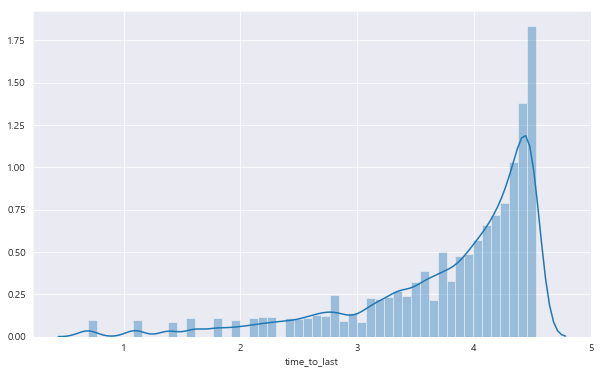

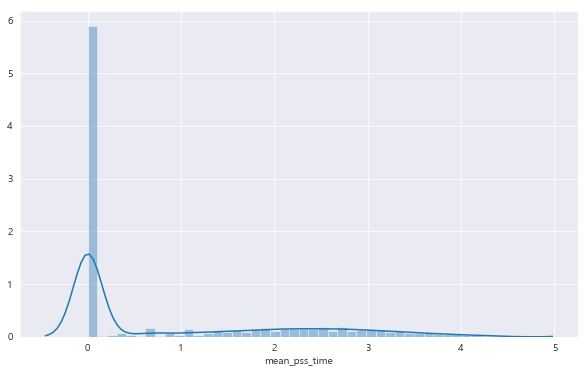

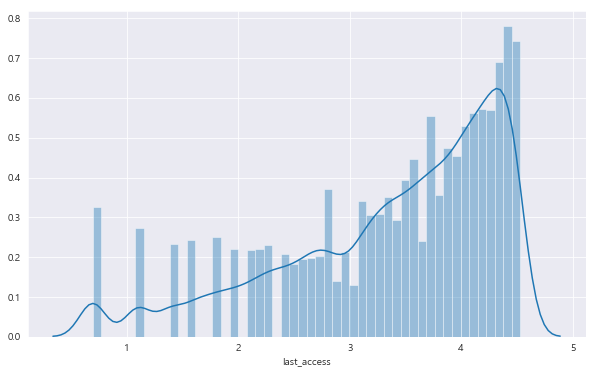

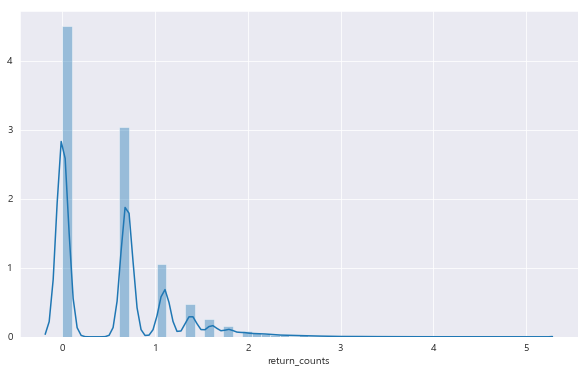

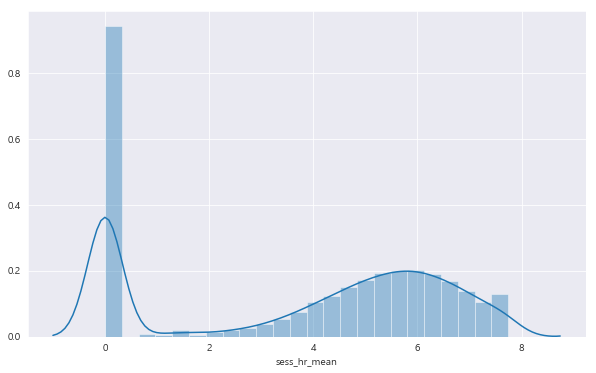

In [229]:
for col in latent.columns:
    plt.figure(figsize = (10,6))
    sns.distplot(np.log1p(latent[col]))
    plt.show()

In [8]:
audience = pd.read_csv("dataset_audience.csv")

In [19]:
audience.head()

,clnt_id,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,...,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
0,1,-0.916604,-0.596175,-1.076638,0.006850,-0.572638,1.369690,0.434900,1.000000,-1,...,0,0,1,0,0,0,0,0,0,1
1,3,0.741973,1.164989,1.023003,-0.721786,-0.572638,2.245919,1.186551,1.000000,-1,...,0,0,1,0,0,0,0,0,0,1
2,5,0.009331,0.642185,0.428463,-0.721786,-0.572638,1.403692,0.945330,-1.000000,-1,...,0,0,1,0,0,0,0,0,0,1
3,6,0.818796,0.023005,0.793101,0.006850,-0.572638,2.175032,1.681143,0.591954,-1,...,0,0,1,0,0,0,0,0,0,1
4,7,0.891177,-0.518449,0.428463,1.252462,-0.572638,0.789822,0.329054,0.833333,-1,...,0,0,1,0,0,0,0,0,0,1


In [20]:
mergings = linkage(audience.drop("clnt_id", axis=1), method="complete")

In [22]:
with open("linkage_2.pickle", "wb") as f:
     pickle.dump(mergings, f, protocol=pickle.HIGHEST_PROTOCOL)

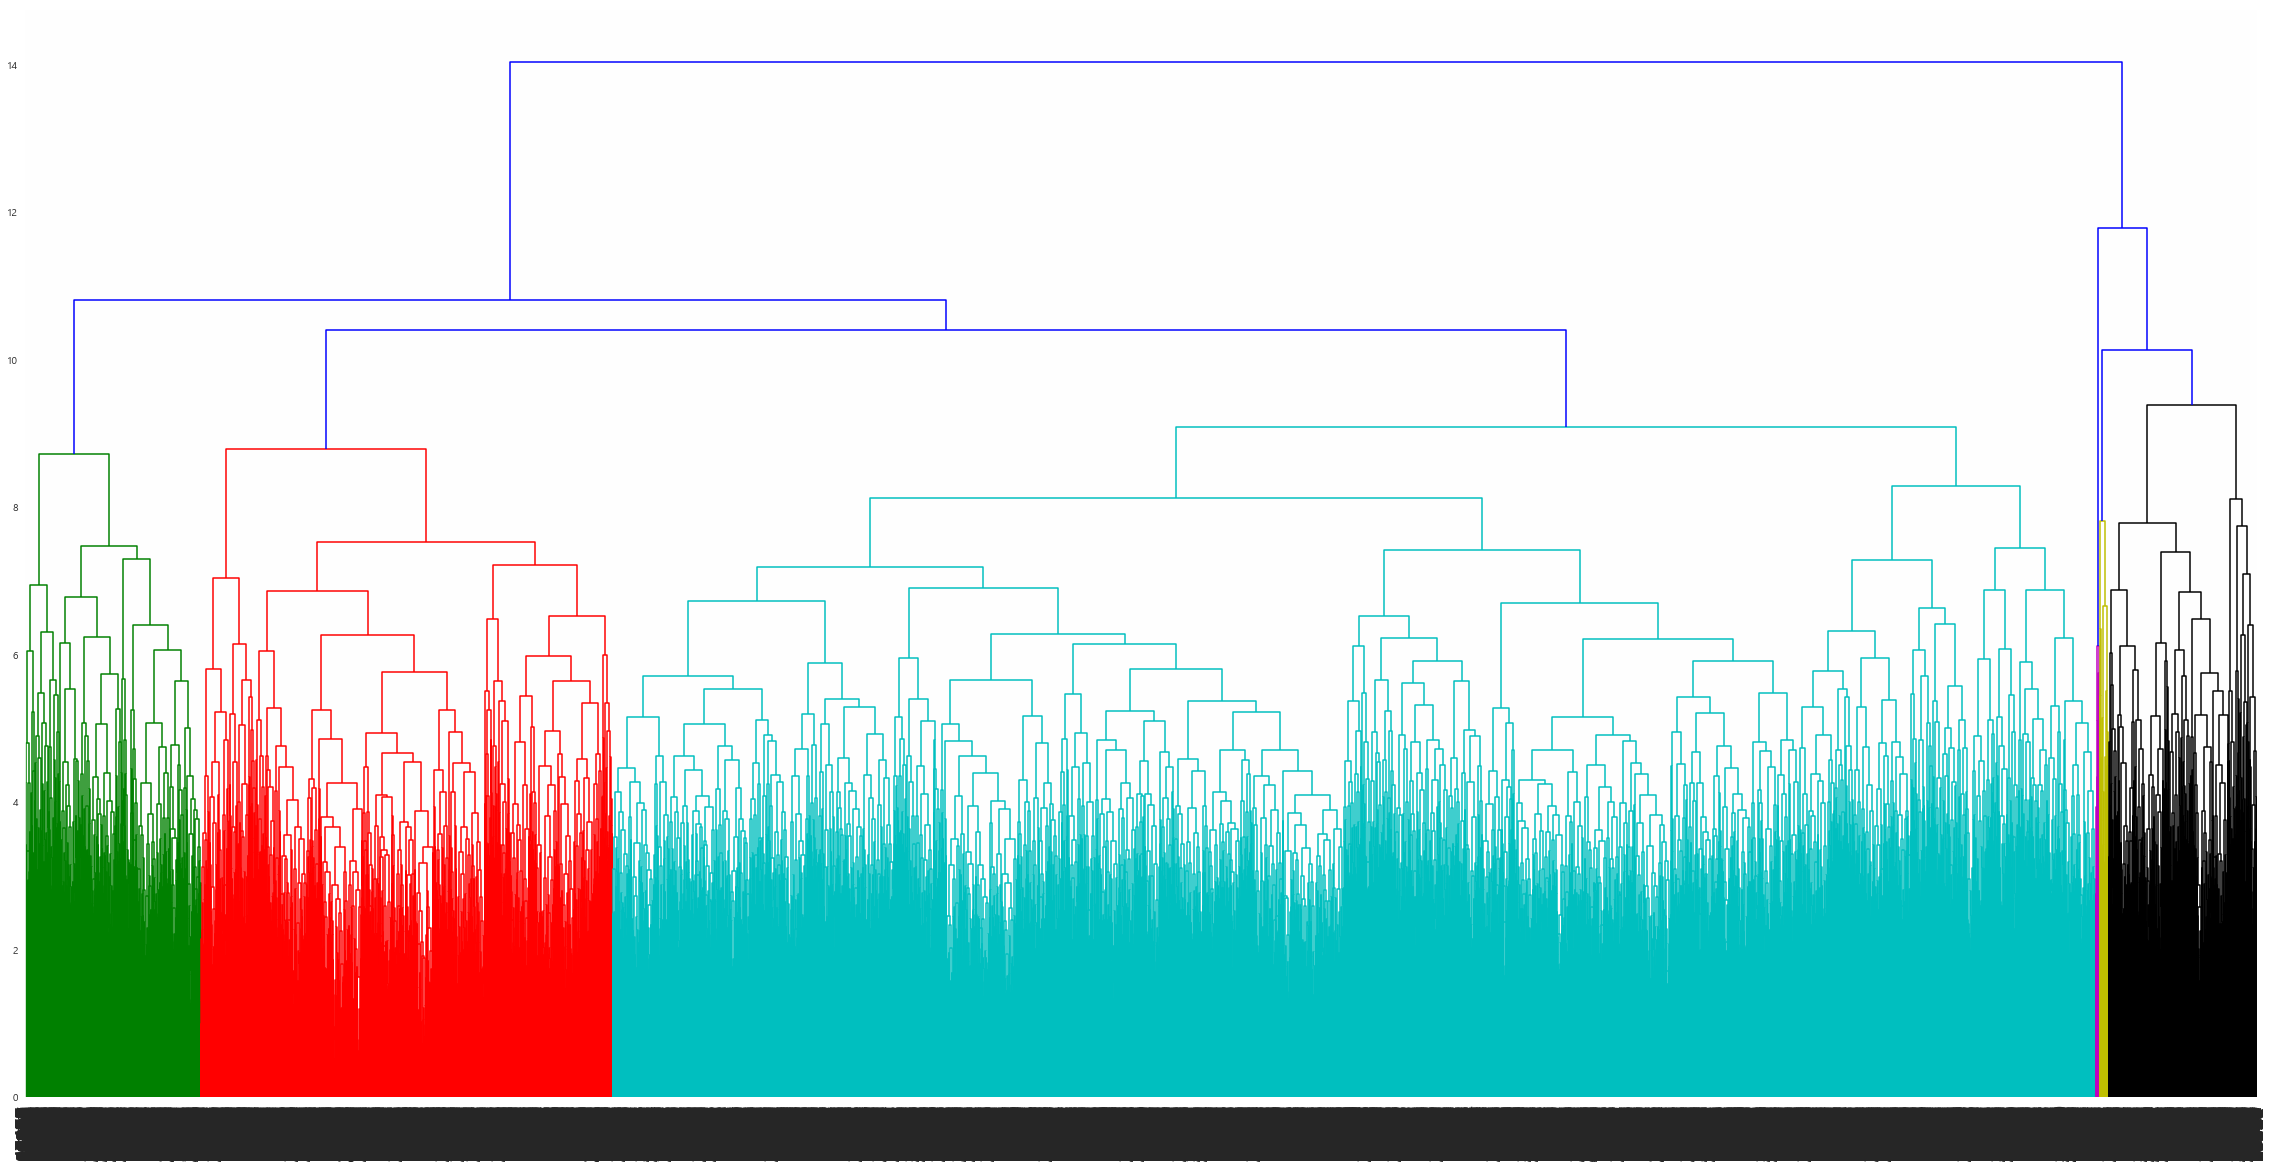

In [23]:
plt.figure(figsize=(40,20))
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=20,
)
plt.show()

In [5]:
"""with open("linkage.pickle", "wb") as f:
     pickle.dump(mergings, f, protocol=pickle.HIGHEST_PROTOCOL)"""

'with open("linkage.pickle", "wb") as f:\n     pickle.dump(mergings, f, protocol=pickle.HIGHEST_PROTOCOL)'

In [3]:
with open("linkage_2.pickle", "rb") as f:
     mergings = pickle.load(f)

In [17]:
pd.options.display.max_columns = 60

In [25]:
predict = pd.DataFrame(fcluster(mergings,10,criterion='distance'))

predict.rename(columns = {0 : "group"}, inplace = True)
predict["group"].value_counts()

3    34278
2     9500
1     4066
6     3431
5      212
4       79
Name: group, dtype: int64

In [19]:
info_by_group = pd.concat([audience, predict], axis=1).groupby("group").mean().drop("clnt_id", axis = 1).reset_index()
info_by_group

,group,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,return_rate,action_0,action_1,action_2,action_3,action_4,action_5,src_DIRECT,src_PORTAL_1,src_PORTAL_2,src_PORTAL_3,src_PUSH,src_unknown,src_WEBSITE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,shopping_day_holiday,shopping_day_weekday,time_range_dawn,time_range_daytime,time_range_night,biz_unit_A01,biz_unit_A02,biz_unit_A03,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
0,1,-2.249228,-1.168854,-1.587280,-0.379660,-0.216621,-0.188833,-0.205872,-0.398862,-1.0,0.190895,0.262739,0.094280,0.526389,0.035808,0.004645,0.073929,0.113970,0.069733,0.004591,0.009612,0.036485,0.752255,0.013353,0.207819,0.095580,0.094957,0.114125,0.128764,0.168066,0.190672,0.209051,0.109444,0.633301,0.047221,0.391786,0.608214,0.099606,0.473684,0.426709,0.212002,0.632317,0.155681,0.000246,0.000000,0.999754,0.0,0.000000,0.000000,0.000000,0.000246,0.000000,0.999754
1,2,0.194058,0.014489,0.031371,0.090391,0.965459,-1.125475,-1.248660,-0.755196,-1.0,0.677915,0.088489,0.078163,0.780121,0.006327,0.000398,0.046017,0.021173,0.039529,0.000873,0.021013,0.003631,0.869030,0.044751,0.150842,0.149851,0.138663,0.142589,0.122839,0.144964,0.150200,0.169579,0.019053,0.807789,0.001895,0.319684,0.680316,0.088737,0.506737,0.404526,0.051053,0.868947,0.080000,0.000105,0.000000,0.999895,0.0,0.000000,0.000105,0.000000,0.000000,0.000000,0.999895
2,3,0.151588,0.267437,0.266831,-0.234257,-0.428549,0.329342,0.325536,0.050923,-1.0,0.047010,0.410151,0.092723,0.326202,0.069074,0.010634,0.088818,0.240495,0.083684,0.010784,0.007630,0.068844,0.566442,0.022122,0.163315,0.167561,0.153345,0.143559,0.128331,0.118383,0.125483,0.205350,0.160861,0.529261,0.103273,0.263347,0.736653,0.091371,0.551316,0.357314,0.263959,0.403612,0.332429,0.001838,0.000292,0.997870,0.0,0.000321,0.000583,0.000700,0.000438,0.000088,0.997870
3,4,0.763532,-2.093196,-1.451223,5.084709,5.875397,-0.657539,0.242408,-0.537350,-1.0,0.736922,0.026405,0.041684,0.869544,0.025823,0.004595,0.031886,0.074747,0.001177,0.005089,0.020000,0.002949,0.482696,0.413329,0.173544,0.161709,0.150646,0.143848,0.147544,0.111481,0.111266,0.379747,0.000000,0.594937,0.000000,0.012658,0.987342,0.113924,0.797468,0.088608,0.000000,0.493671,0.506329,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,5,0.780598,-1.886486,-1.470510,4.434675,0.059005,1.357307,1.048009,0.649742,-1.0,0.016914,0.491618,0.096575,0.196920,0.082830,0.032462,0.099222,0.353896,0.015656,0.028047,0.007231,0.052599,0.507297,0.035259,0.158703,0.157566,0.156835,0.152580,0.142580,0.121396,0.110269,0.183962,0.415094,0.099057,0.278302,0.047170,0.952830,0.080189,0.702830,0.216981,0.363208,0.235849,0.400943,0.018868,0.000000,0.981132,0.0,0.000000,0.004717,0.014151,0.000000,0.000000,0.981132
5,6,0.547905,-1.162053,-0.747355,2.148937,1.726047,-0.018997,0.378693,-0.262333,-1.0,0.428207,0.128714,0.099949,0.594122,0.059595,0.014257,0.103039,0.163023,0.013530,0.005305,0.005608,0.039818,0.666395,0.106321,0.163063,0.150630,0.151048,0.143586,0.133723,0.125386,0.132645,0.135238,0.071699,0.655494,0.130283,0.159429,0.840571,0.056835,0.589041,0.354124,0.027397,0.653162,0.319440,0.004372,0.000291,0.995337,0.0,0.000000,0.000874,0.002623,0.000874,0.000291,0.995337


In [24]:
# info_by_group.to_csv("그룹별정보.csv", index = False)

Group_1 :

Group_2 : 

Group_3 : 
=> 첫접속일 오래됨. 마지막접속일 비교적 최근. 해당 기간동안 자주 접속. 총 sess_count많은편. 반송률이 낮음. 평균 page_view수도 평균보단 조금 많은 편. 검색은 평균보다 적게 하는편. action2의 비중이 비교적 낮은편

Group_4 : 
=> 첫접속일 오래됨. 마지막접속일 비교적 최근. 해당 기간동안 자주 접속. 총 sess_count많은편. but 반송률이 높음. 따라서 평균 page_view수도 작은 값을 보임. 검색은 평균보다 적게 하는편. action2의 비중이 높음( 상세정보를 주로 보는편 or 반송률이 높은것을 보아 잘못 들어오는 경우가 많을 수도 있음 ). 다른 그룹에 비해 website를 통해 접속하는 경우가 많음. 주로 mobile_web을 통해 접속하는 경향. biz_unit은 A02가 대부분

Group_ :5

In [14]:
predict = pd.DataFrame(fcluster(mergings,7,criterion='distance'))

predict.rename(columns = {0 : "group"}, inplace = True)
predict["group"].value_counts()

11    10398
13     7325
10     6498
7      5294
12     3202
14     2563
9      2361
17     1796
4      1637
2      1447
15     1428
23     1349
16     1068
21      863
1       781
5       649
6       605
8       591
22      543
27      232
3       201
24      180
20      175
26      172
25       92
18       79
19       37
Name: group, dtype: int64

In [15]:
silhouette_score (audience, predict)

c:\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



-0.132043644310685

In [115]:
info_by_group = pd.concat([audience, predict], axis=1).groupby("group").mean().drop("clnt_id", axis = 1).reset_index()
info_by_group

,group,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,return_rate,action_0,action_1,action_2,action_3,action_4,action_5,action_6,action_7,src_DIRECT,src_PORTAL_1,src_PORTAL_2,src_PORTAL_3,src_PUSH,src_unknown,src_WEBSITE,purchase_count,...,weekday_3,weekday_4,weekday_5,weekday_6,mean_buy_ct,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,shopping_day_holiday,shopping_day_weekday,time_range_dawn,time_range_daytime,time_range_night,biz_unit_A01,biz_unit_A02,biz_unit_A03,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
0,1,0.760471,-2.072944,-1.785974,5.200525,5.934235,-0.847802,-1.369891,-0.665763,-1.0,0.718977,0.013000,0.042574,0.876559,0.021985,0.004941,0.040926,0.0,0.000044,0.056765,0.000632,0.004176,0.024971,0.001618,0.578162,0.333662,0.014706,...,0.139397,0.139412,0.129735,0.134426,0.014706,0.250000,0.000000,0.735294,0.000000,0.088235,0.911765,0.161765,0.735294,0.102941,0.000000,0.602941,0.397059,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,2,0.696986,-1.642543,-1.267599,3.812482,3.691295,-0.406874,-1.362774,-0.063424,-1.0,0.512719,0.124997,0.103070,0.631924,0.048334,0.012564,0.078720,0.0,0.000360,0.117732,0.013150,0.011914,0.004468,0.014955,0.646115,0.191650,0.038217,...,0.142516,0.134417,0.120564,0.117025,0.025478,0.302548,0.047771,0.611465,0.006369,0.073248,0.926752,0.063694,0.652866,0.283439,0.028662,0.640127,0.331210,0.012739,0.000000,0.987261,0.0,0.000000,0.000000,0.009554,0.003185,0.000000,0.987261
2,3,0.595696,-0.859883,-0.904411,1.911506,2.597823,-0.900914,-1.361530,-0.853509,-1.0,0.678808,0.016999,0.070081,0.817724,0.020184,0.002952,0.071791,0.0,0.000260,0.036772,0.009009,0.001248,0.010529,0.009574,0.772391,0.160480,0.005063,...,0.133282,0.134191,0.127268,0.146710,0.003291,0.115443,0.005570,0.870380,0.004557,0.182785,0.817215,0.076962,0.520506,0.402532,0.000000,0.785823,0.214177,0.003038,0.000000,0.996962,0.0,0.000000,0.000506,0.002025,0.000506,0.000000,0.996962
3,4,-1.220584,-1.060703,-1.398312,0.448462,1.015652,-0.713886,-1.340606,-0.770574,-1.0,0.554507,0.047950,0.104780,0.740327,0.021034,0.002036,0.083870,0.0,0.000000,0.037161,0.027358,0.001266,0.008451,0.016384,0.857969,0.051410,0.000000,...,0.136898,0.109752,0.195723,0.148685,0.000000,0.220413,0.010858,0.763301,0.005429,0.370250,0.629750,0.066232,0.479913,0.453855,0.007600,0.859935,0.132465,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,5,0.325245,-0.218214,0.162189,0.277321,0.826641,-0.785402,-1.161679,-0.594800,-1.0,0.575874,0.113788,0.099698,0.690903,0.021765,0.003066,0.069864,0.0,0.000921,0.044994,0.033263,0.002871,0.015400,0.019337,0.841708,0.042427,0.004424,...,0.142167,0.129337,0.125905,0.145667,0.003269,0.176670,0.060979,0.747161,0.012461,0.306666,0.693334,0.080593,0.489530,0.429878,0.051172,0.825173,0.123654,0.001254,0.000442,0.998304,0.0,0.000442,0.000590,0.000074,0.000516,0.000074,0.998304
5,6,0.684393,-1.708414,-1.658034,4.019142,-0.049242,0.617144,0.206414,0.599223,-1.0,0.021919,0.380231,0.105704,0.206753,0.120134,0.047061,0.139842,0.0,0.000291,0.476348,0.003988,0.026522,0.009518,0.118061,0.344757,0.020794,0.044534,...,0.148725,0.135879,0.111830,0.099190,0.026316,0.202429,0.242915,0.076923,0.469636,0.020243,0.979757,0.056680,0.769231,0.174089,0.202429,0.198381,0.599190,0.004049,0.000000,0.995951,0.0,0.000000,0.004049,0.000000,0.000000,0.000000,0.995951
6,7,0.531362,-1.008390,-1.011051,2.137676,-0.533137,0.611427,0.768319,0.328941,-1.0,0.003747,0.367293,0.104495,0.294148,0.095055,0.025200,0.111831,0.0,0.001986,0.298937,0.006978,0.006183,0.001768,0.071087,0.604023,0.011023,0.026963,...,0.145171,0.142903,0.123255,0.124595,0.023791,0.099128,0.472641,0.157811,0.267248,0.140365,0.859635,0.057891,0.600317,0.341792,0.222046,0.402062,0.375892,0.012688,0.000793,0.986519,0.0,0.000000,0.00

* time_to_last : 현재로부터 첫 접속일시까지의 기간 ( 값이 작으면 첫 접속일이 비교적 최근 , 값이 크면 첫 접속일이 먼 편 - 7월에 가까움)
* mean_pss_time : 접속기록이 있던 기간 중 평균 접속 텀 ( 값이 작으면 해당기간 내에 자주 접속, 값이 크면 접속 주기가 긴 편 )
* last_access : 현재로부터 마지막 접속일시까지의 기간
* tot_sess_cnt : clnt_id별 총 session의 갯수
* return_counts : return한 session의 총 갯수
* pag_view_mean : clnt_id별 총 page_view수의 평균 ( 총 page_view수 / 총 session의 수 )
* sess_hr_mean : clnt_id별 세션접속시간의 평균
* search_rate_0 : 구매하지 않은 session에서의 검색비율
* search_rate_1 : 구매한 session에서의 검색비율

In [26]:
# info_by_group.to_csv("그룹별정보_2.csv", index = False)

In [26]:
audience_with_group = pd.concat([audience, predict], axis=1)

In [27]:
audience_with_group.to_csv("audience_with_group.csv", index = False)

In [14]:
base = pd.read_csv("dataset_normal.csv")
# base.loc[base.pag_view_mean.isnull(), "pag_view_mean"] = base.pag_view_mean.mean()
base.head()

,clnt_id,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,...,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
0,2,0.276459,-1.234380,0.459161,1.206326,-0.391202,0.533010,0.635531,0.595735,0.194696,...,1,0,0,0,0,1,0,0,0,0
1,4,-0.544534,0.969974,0.609701,-1.045971,-0.391202,1.717706,0.110554,-1.000000,0.500000,...,0,0,1,0,0,0,0,0,0,1
2,9,0.762958,-0.996520,-0.806956,1.667861,-0.391202,-0.275433,-0.131782,0.482529,0.142857,...,1,0,0,0,0,0,1,0,0,0
3,12,0.476592,1.561120,1.222150,-1.045971,-0.391202,0.038612,-2.016339,-1.000000,0.500000,...,1,0,0,0,0,0,1,0,0,0
4,17,0.254800,-0.558956,0.757128,0.006350,-0.391202,0.836387,1.301796,0.188312,0.250000,...,0,0,1,0,0,0,0,0,0,1


In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [32]:
compare_performances = {}
stf = StratifiedKFold(n_splits=3, random_state=42)

for i in range(2,7):
    n_neighbors = i
    for distance in ["minkowski","euclidean","manhattan"]:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = distance, n_jobs=-1)
        oof = np.zeros(audience_with_group.shape[0])
        for j, (train_idx, valid_idx) in enumerate(stf.split(audience_with_group.drop(["clnt_id","group"],axis=1), audience_with_group.group)) :
            print("Fold Num {} - N_neighbors : {}, Distance : {}".format(j+1, i, distance))
            train_X, valid_X = audience_with_group.drop(["clnt_id","group"],axis=1).iloc[train_idx,:], audience_with_group.drop(["clnt_id","group"],axis=1).iloc[valid_idx,:]
            train_y, valid_y = audience_with_group.group[train_idx], audience_with_group.group[valid_idx]
            
            knn.fit(train_X, train_y)
            
            oof[valid_idx] = knn.predict(valid_X)
        acc_score = accuracy_score(audience_with_group.group, oof)
        f1_macro = f1_score(audience_with_group.group, oof,average="macro")
        f1_micro = f1_score(audience_with_group.group, oof,average="micro")
        performances = {"acc_score" : acc_score, "f1_macro" : f1_macro, "f1_micro" : f1_micro}
        print(performances)
        compare_performances["distance_{}_n_neighbors_{}".format(distance, n_neighbors)] = performances

Fold Num 1 - N_neighbors : 2, Distance : minkowski
Fold Num 2 - N_neighbors : 2, Distance : minkowski
Fold Num 3 - N_neighbors : 2, Distance : minkowski
{'acc_score': 0.9429856882441919, 'f1_macro': 0.8911401791487537, 'f1_micro': 0.9429856882441919}
Fold Num 1 - N_neighbors : 2, Distance : euclidean
Fold Num 2 - N_neighbors : 2, Distance : euclidean
Fold Num 3 - N_neighbors : 2, Distance : euclidean
{'acc_score': 0.9429856882441919, 'f1_macro': 0.8911401791487537, 'f1_micro': 0.9429856882441919}
Fold Num 1 - N_neighbors : 2, Distance : manhattan
Fold Num 2 - N_neighbors : 2, Distance : manhattan
Fold Num 3 - N_neighbors : 2, Distance : manhattan
{'acc_score': 0.9280145832525307, 'f1_macro': 0.8640052299770803, 'f1_micro': 0.9280145832525307}
Fold Num 1 - N_neighbors : 3, Distance : minkowski
Fold Num 2 - N_neighbors : 3, Distance : minkowski
Fold Num 3 - N_neighbors : 3, Distance : minkowski
{'acc_score': 0.9532443858356281, 'f1_macro': 0.9019228302591981, 'f1_micro': 0.95324438583562

In [1]:
from sklearn.metrics import silhouette_score

In [33]:
"""
with open("performance_dict.pickle", "wb") as f:
    pickle.dump(compare_performances, f, protocol=pickle.HIGHEST_PROTOCOL)
"""

* Best_Parameter Set => n_neighbors = 3, distance = (minkowski or euclidean)

In [138]:
# compare_performances

In [3]:
# sorted(info_by_group.columns.tolist())

In [28]:
knn = KNeighborsClassifier(n_neighbors=3, metric = "euclidean")

In [29]:
knn.fit(audience_with_group.drop(["clnt_id","group"], axis=1), audience_with_group.group)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [30]:
with open("knn_model.pickle", "wb") as f:
    pickle.dump(knn, f, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open("knn_model.pickle", "rb") as f:
    load_knn = pickle.load(f)

In [38]:
pd.DataFrame(knn.predict(base.drop("clnt_id", axis=1)))[0].value_counts()

3    15306
2     2264
6     2066
1     1165
5       25
4        7
Name: 0, dtype: int64

In [ ]:
# hit_pss_tm
# 구매당시 시간정보 + 구매까지의 총 hit_seq갯수
# 장바구니 이용 비율

In [41]:
base_with_group = pd.concat([base, pd.DataFrame(knn.predict(base.drop("clnt_id", axis=1))).rename(columns = { 0 : "group"})], axis=1)

In [42]:
base_with_group.to_csv("normal_with_group.csv", index = False)

In [45]:
info_by_group

,group,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,return_rate,action_0,action_1,action_2,action_3,action_4,action_5,src_DIRECT,src_PORTAL_1,src_PORTAL_2,src_PORTAL_3,src_PUSH,src_unknown,src_WEBSITE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,shopping_day_holiday,shopping_day_weekday,time_range_dawn,time_range_daytime,time_range_night,biz_unit_A01,biz_unit_A02,biz_unit_A03,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
0,1,-2.249228,-1.168854,-1.587280,-0.379660,-0.216621,-0.188833,-0.205872,-0.398862,-1.0,0.190895,0.262739,0.094280,0.526389,0.035808,0.004645,0.073929,0.113970,0.069733,0.004591,0.009612,0.036485,0.752255,0.013353,0.207819,0.095580,0.094957,0.114125,0.128764,0.168066,0.190672,0.209051,0.109444,0.633301,0.047221,0.391786,0.608214,0.099606,0.473684,0.426709,0.212002,0.632317,0.155681,0.000246,0.000000,0.999754,0.0,0.000000,0.000000,0.000000,0.000246,0.000000,0.999754
1,2,0.194058,0.014489,0.031371,0.090391,0.965459,-1.125475,-1.248660,-0.755196,-1.0,0.677915,0.088489,0.078163,0.780121,0.006327,0.000398,0.046017,0.021173,0.039529,0.000873,0.021013,0.003631,0.869030,0.044751,0.150842,0.149851,0.138663,0.142589,0.122839,0.144964,0.150200,0.169579,0.019053,0.807789,0.001895,0.319684,0.680316,0.088737,0.506737,0.404526,0.051053,0.868947,0.080000,0.000105,0.000000,0.999895,0.0,0.000000,0.000105,0.000000,0.000000,0.000000,0.999895
2,3,0.151588,0.267437,0.266831,-0.234257,-0.428549,0.329342,0.325536,0.050923,-1.0,0.047010,0.410151,0.092723,0.326202,0.069074,0.010634,0.088818,0.240495,0.083684,0.010784,0.007630,0.068844,0.566442,0.022122,0.163315,0.167561,0.153345,0.143559,0.128331,0.118383,0.125483,0.205350,0.160861,0.529261,0.103273,0.263347,0.736653,0.091371,0.551316,0.357314,0.263959,0.403612,0.332429,0.001838,0.000292,0.997870,0.0,0.000321,0.000583,0.000700,0.000438,0.000088,0.997870
3,4,0.763532,-2.093196,-1.451223,5.084709,5.875397,-0.657539,0.242408,-0.537350,-1.0,0.736922,0.026405,0.041684,0.869544,0.025823,0.004595,0.031886,0.074747,0.001177,0.005089,0.020000,0.002949,0.482696,0.413329,0.173544,0.161709,0.150646,0.143848,0.147544,0.111481,0.111266,0.379747,0.000000,0.594937,0.000000,0.012658,0.987342,0.113924,0.797468,0.088608,0.000000,0.493671,0.506329,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,5,0.780598,-1.886486,-1.470510,4.434675,0.059005,1.357307,1.048009,0.649742,-1.0,0.016914,0.491618,0.096575,0.196920,0.082830,0.032462,0.099222,0.353896,0.015656,0.028047,0.007231,0.052599,0.507297,0.035259,0.158703,0.157566,0.156835,0.152580,0.142580,0.121396,0.110269,0.183962,0.415094,0.099057,0.278302,0.047170,0.952830,0.080189,0.702830,0.216981,0.363208,0.235849,0.400943,0.018868,0.000000,0.981132,0.0,0.000000,0.004717,0.014151,0.000000,0.000000,0.981132
5,6,0.547905,-1.162053,-0.747355,2.148937,1.726047,-0.018997,0.378693,-0.262333,-1.0,0.428207,0.128714,0.099949,0.594122,0.059595,0.014257,0.103039,0.163023,0.013530,0.005305,0.005608,0.039818,0.666395,0.106321,0.163063,0.150630,0.151048,0.143586,0.133723,0.125386,0.132645,0.135238,0.071699,0.655494,0.130283,0.159429,0.840571,0.056835,0.589041,0.354124,0.027397,0.653162,0.319440,0.004372,0.000291,0.995337,0.0,0.000000,0.000874,0.002623,0.000874,0.000291,0.995337


In [44]:
base_with_group.groupby("group").mean()

,clnt_id,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,return_rate,action_0,action_1,action_2,action_3,action_4,action_5,src_DIRECT,src_PORTAL_1,src_PORTAL_2,src_PORTAL_3,src_PUSH,src_unknown,src_WEBSITE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,shopping_day_holiday,shopping_day_weekday,time_range_dawn,time_range_daytime,time_range_night,biz_unit_A01,biz_unit_A02,biz_unit_A03,clnt_gender_F,clnt_gender_M,clnt_gender_unknown,clnt_age_10,clnt_age_20,clnt_age_30,clnt_age_40,clnt_age_50,clnt_age_60,clnt_age_unknown
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,35127.217167,-2.646492,-0.649211,-0.927837,-0.666922,-0.300453,-0.166382,-0.372259,-0.699415,-0.616728,0.019207,0.131288,0.027507,0.164371,0.046052,0.009494,0.224096,0.156102,0.013344,0.004549,0.002897,0.043500,0.758130,0.021478,0.185261,0.113582,0.122720,0.136076,0.119830,0.155130,0.167394,0.155365,0.237768,0.497854,0.107296,0.338197,0.661803,0.084979,0.529614,0.385408,0.412876,0.395708,0.191416,0.283262,0.080687,0.636052,0.005150,0.039485,0.144206,0.128755,0.039485,0.006867,0.636052
2,37030.107332,0.118270,0.110034,0.099424,-0.128606,1.033711,-1.222289,-1.130905,-0.665329,-0.796005,0.242660,0.062278,0.050882,0.363366,0.031374,0.004672,0.264917,0.045393,0.016296,0.004449,0.004101,0.019069,0.869719,0.040974,0.160033,0.144189,0.126975,0.131911,0.109927,0.184146,0.142834,0.129859,0.165194,0.699205,0.003092,0.309187,0.690813,0.053004,0.558304,0.388693,0.147968,0.763251,0.088781,0.390459,0.081272,0.528269,0.003092,0.046820,0.179770,0.174470,0.055212,0.012367,0.528269
3,35455.200183,0.101023,0.190784,0.209290,-0.171791,-0.282691,0.167503,0.118947,-0.127722,-0.288096,0.016383,0.244871,0.048173,0.146256,0.101318,0.022551,0.195627,0.329339,0.024960,0.009063,0.002777,0.077646,0.535998,0.020216,0.168795,0.162204,0.154575,0.141318,0.132266,0.116777,0.124057,0.130602,0.274598,0.343133,0.249183,0.208154,0.791846,0.053312,0.624461,0.322227,0.335751,0.261401,0.402849,0.502025,0.092774,0.405201,0.002091,0.047302,0.212466,0.236705,0.081275,0.014961,0.405201
4,38737.428571,0.736253,-1.683193,-1.292859,2.829816,7.797413,-0.532519,0.023883,0.106608,-0.366725,0.631534,0.191286,0.071000,0.468286,0.120000,0.045571,0.079429,0.175000,0.007429,0.009429,0.000000,0.009143,0.274714,0.524286,0.172000,0.148571,0.149000,0.130571,0.154571,0.137571,0.107571,0.571429,0.000000,0.428571,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.142857,0.142857,0.714286,0.285714,0.142857,0.571429,0.000000,0.000000,0.285714,0.000000,0.000000,0.142857,0.571429
5,36809.200000,0.756183,-1.838941,-1.774489,3.380243,0.591457,1.284217,0.826257,0.693373,0.418850,0.005007,0.482600,0.063800,0.085120,0.110480,0.047800,0.177400,0.296840,0.000000,0.000000,0.000000,0.262080,0.440000,0.001080,0.160880,0.157640,0.172400,0.141600,0.142080,0.111160,0.114280,0.000000,0.440000,0.000000,0.560000,0.000000,1.000000,0.000000,1.000000,0.000000,0.440000,0.000000,0.560000,0.680000,0.120000,0.200000,0.000000,0.040000,0.240000,0.240000,0.240000,0.040000,0.200000
6,38135.714908,0.602651,-1.139968,-1.110429,1.739226,1.097387,0.178564,0.557905,0.335957,0.003429,0.121311,0.147334,0.085690,0.224565,0.187798,0.055974,0.254780,0.529834,0.005970,0.003678,0.001424,0.165619,0.237616,0.055861,0.183656,0.149264,0.163182,0.140098,0.136766,0.118627,0.108347,0.057599,0.084705,0.242014,0.604066,0.028558,0.971442,0.017425,0.859632,0.122943,0.011133,0.229913,0.758955,0.653921,0.087125,0.258955,0.000484,0.017425,0.216360,0.357212,0.122943,0.026621,0.258955


In [47]:
cat_buy = pd.read_csv("purchase_num_by_category.csv")

In [73]:
tmp_df = base_with_group.merge(cat_buy)

In [84]:
tmp_df.iloc[:,54:].values[0]

array([1, 2, 1, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [88]:
tmp_df.iloc[:,54:].values[0] / tmp_df.iloc[:,54:].values[0].sum()

array([0.1, 0.2, 0.1, 0.1, 0.2, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. ])

In [91]:
tmp_df.iloc[:,54:].values.sum(axis=1)

array([10,  1, 17, ...,  1,  2,  1], dtype=int64)

In [92]:
tmp_df.iloc[:,54:].values,tmp_df.iloc[:,54:].values.sum(axis=1)

ValueError: operands could not be broadcast together with shapes (20833,57) (20833,) 

In [100]:
lst = []
for i in range(tmp_df.shape[0]):
    lst.append(tmp_df.iloc[:,54:].values[i] / tmp_df.iloc[:,54:].values[i].sum())

In [102]:
buy_percentage = pd.DataFrame(lst)

In [109]:
buy_percentage.columns = cat_buy.columns[1:]

In [111]:
buy_percentage.head()

,unknown,Beverages,Canned / Jarred Foods,Dairy Products,Chilled Foods,Substitute Foods,Frozen Foods,Snack Foods,Personal Care,Spices / Seasonings,Kids' Clothing,Grains,Meats,Bedding / Handicraft,Women's Clothing,Gardening / Pets,Vegetables,Fruits,Kitchenware,Detergents / Hygiene Goods,Cleaning / Laundry / Bathroom Accessories,Fashion Accessories,Cosmetics / Beauty Care,Underwear / Socks and Hosiery / Homewear,Sport Fashion,Stationary / Office Supplies,Tools / Safety Supplies,Dried Sea Foods,Sea Foods,Toy,Seasonal Sports,Coffee / Tea,Health Foods,Heating / Cooling Electronics,Other Products,Home / Kitchen Appliances,Men's Clothing,Refrigerators and Washing Machines,Birth Supplies / Baby Products,Others (Non-Products),Travel / Leisure Services,Health / Fitness Training,Liquors / Alcoholic Beverages,Health Care,Tableware / Cooking Utensils,Cooked Foods,Video / Audio System Electronics,Gift Certificates / Cards,Outdoor / Leisure Activities,Furniture,Baby Foods,Home Decor / Lighting,Ball Game / Field Sports,Computers,Cell Phones / Accessories,Books / Records / Instruments,Automotive Products
0,0.1,0.200000,0.1,0.100000,0.200000,0.300000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.058824,0.0,0.176471,0.058824,0.176471,0.294118,0.117647,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
base_customer = pd.concat([base_with_group, buy_percentage], axis=1)

In [118]:
base_customer.to_csv("normal_cust_info.csv", index = False)

In [119]:
base_customer

,clnt_id,time_to_last,mean_pss_time,last_access,tot_sess_cnt,return_counts,pag_view_mean,sess_hr_mean,search_rate_0,search_rate_1,return_rate,action_0,action_1,action_2,action_3,action_4,action_5,src_DIRECT,src_PORTAL_1,src_PORTAL_2,src_PORTAL_3,src_PUSH,src_unknown,src_WEBSITE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,Dried Sea Foods,Sea Foods,Toy,Seasonal Sports,Coffee / Tea,Health Foods,Heating / Cooling Electronics,Other Products,Home / Kitchen Appliances,Men's Clothing,Refrigerators and Washing Machines,Birth Supplies / Baby Products,Others (Non-Products),Travel / Leisure Services,Health / Fitness Training,Liquors / Alcoholic Beverages,Health Care,Tableware / Cooking Utensils,Cooked Foods,Video / Audio System Electronics,Gift Certificates / Cards,Outdoor / Leisure Activities,Furniture,Baby Foods,Home Decor / Lighting,Ball Game / Field Sports,Computers,Cell Phones / Accessories,Books / Records / Instruments,Automotive Products
0,2,0.276459,-1.234380,0.459161,1.206326,-0.391202,0.533010,0.635531,0.595735,0.194696,0.000000,0.180,0.129,0.216,0.082,0.008,0.345,1.000,0.0,0.0,0.0,0.000,0.0,0.000,0.333,0.048,0.143,0.095,0.048,0.238,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,4,-0.544534,0.969974,0.609701,-1.045971,-0.391202,1.717706,0.110554,-1.000000,0.500000,0.000000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,1.0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,9,0.762958,-0.996520,-0.806956,1.667861,-0.391202,-0.275433,-0.131782,0.482529,0.142857,0.000000,0.116,0.077,0.151,0.282,0.056,0.257,1.000,0.0,0.0,0.0,0.000,0.0,0.000,0.515,0.000,0.364,0.030,0.030,0.030,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,12,0.476592,1.561120,1.222150,-1.045971,-0.391202,0.038612,-2.016339,-1.000000,0.500000,0.000000,0.500,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,1.0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,17,0.254800,-0.558956,0.757128,0.006350,-0.391202,0.836387,1.301796,0.188312,0.250000,0.000000,0.127,0.029,0.098,0.235,0.078,0.422,1.000,0.0,0.0,0.0,0.000,0.0,0.000,0.500,0.167,0.167,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5,19,-0.034728,1.265109,0.915471,-1.045971,-0.391202,2.110890,0.606043,-1.000000,-1.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,1.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6,20,0.210466,1.407055,1.062533,-1.045971,-0.391202,-0.972875,-0.355443,-1.000000,-1.000000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
7,22,0.438761,0.123514,-0.503482,0.154005,-0.391202,1.359816,0.189400,1.000000,0.750000,0.000000,0.923,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,1.0,0.000,0.000,0.333,0.167,0.000,0.167,0.167,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
8,23,0.684563,-0.769438,-0.806956,1.250886,-0.

In [5]:
pd.read_csv("ohe_df.csv").time_to_last.mean()

56.2544095912927